In [14]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical

from collections import defaultdict
import seaborn as sns

from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional, Input

from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import backend as K
import tensorflow as tf

%matplotlib inline

# ****VIZUALIZATION OF THE DATASET****

(393732, 7)


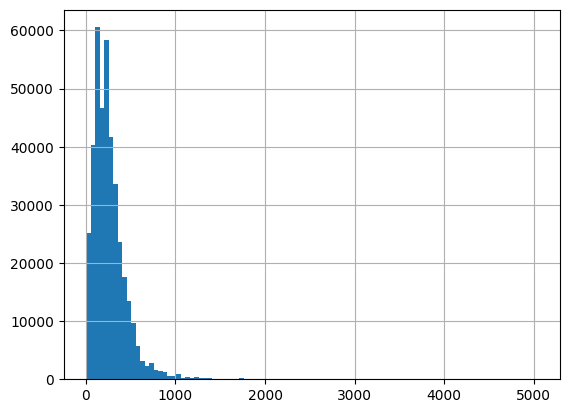

In [16]:
df = pd.read_csv('/kaggle/input/protein-secondary-structure/2018-06-06-ss.cleaned.csv')
df.len.hist(bins=100)
print(df.shape)

In [17]:
df.head()

,pdb_id,chain_code,seq,sst8,sst3,len,has_nonstd_aa
0,1A30,C,EDL,CBC,CEC,3,False
1,1B05,B,KCK,CBC,CEC,3,False
2,1B0H,B,KAK,CBC,CEC,3,False
3,1B1H,B,KFK,CBC,CEC,3,False
4,1B2H,B,KAK,CBC,CEC,3,False


In [18]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393732 entries, 0 to 393731
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   pdb_id         393732 non-null  object
 1   chain_code     393732 non-null  object
 2   seq            393732 non-null  object
 3   sst8           393732 non-null  object
 4   sst3           393732 non-null  object
 5   len            393732 non-null  int64 
 6   has_nonstd_aa  393732 non-null  bool  
dtypes: bool(1), int64(1), object(5)
memory usage: 18.4+ MB
None


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1000x600 with 0 Axes>

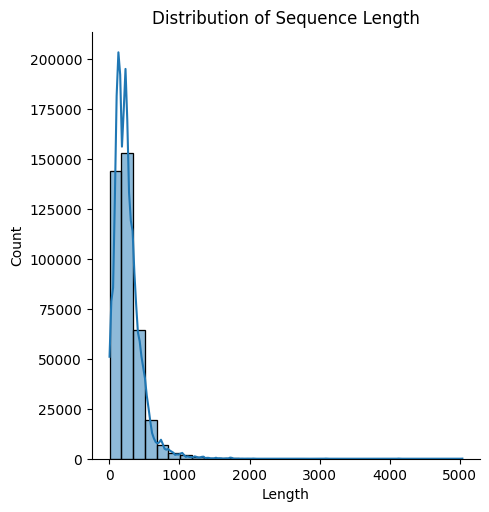

In [22]:
plt.figure(figsize=(10, 6))
sns.displot(df['len'], bins=30, kde=True)
plt.title('Distribution of Sequence Length')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

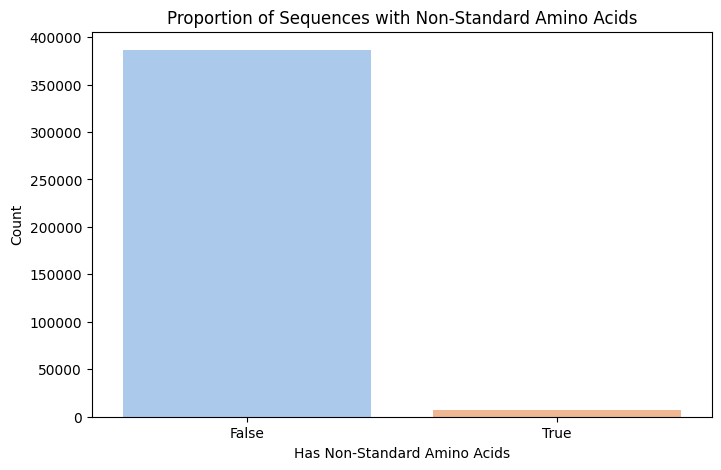

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(x='has_nonstd_aa', data=df, palette='pastel')
plt.title('Proportion of Sequences with Non-Standard Amino Acids')
plt.xlabel('Has Non-Standard Amino Acids')
plt.ylabel('Count')
plt.show()


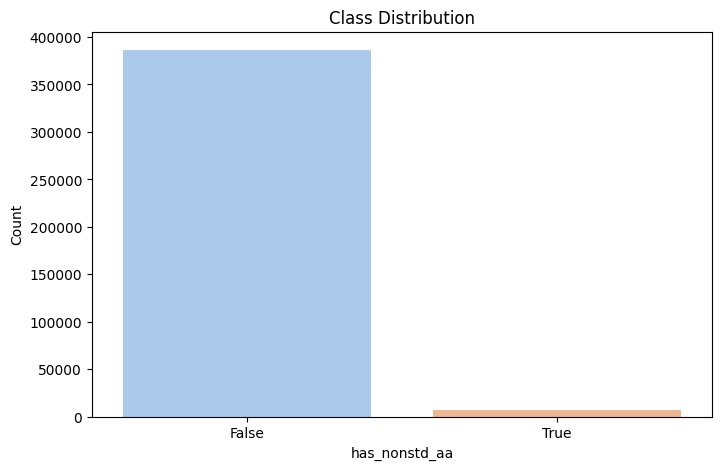

In [24]:
plt.figure(figsize=(8, 5))
sns.countplot(x='has_nonstd_aa', data=df, palette='pastel')
plt.title('Class Distribution')
plt.xlabel('has_nonstd_aa')
plt.ylabel('Count')
plt.show()


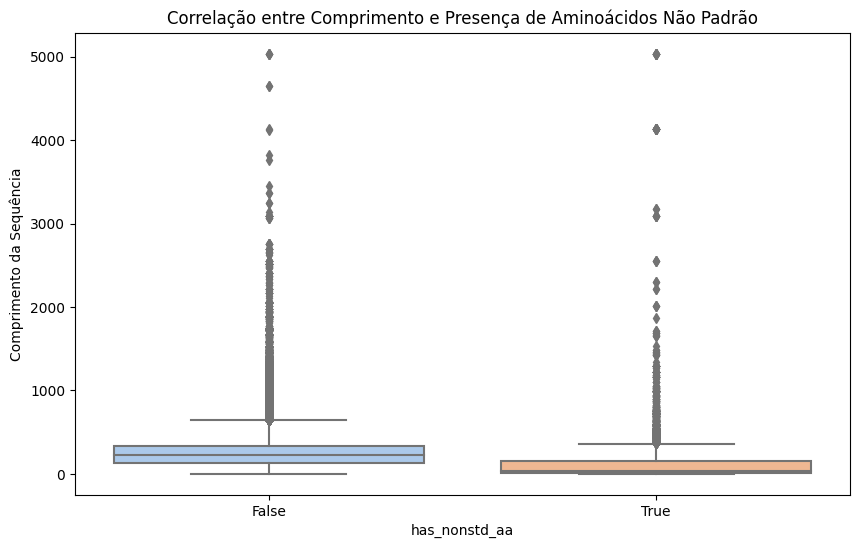

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(x='has_nonstd_aa', data=df, palette='pastel')
plt.title('Proportion of Sequences with Non-Standard Amino Acids')
plt.xlabel('Has Non-Standard Amino Acids')
plt.ylabel('Count')
plt.show()

In [27]:
shortest_sequences = df[df['len'] == df['len'].min()]
longest_sequences = df[df['len'] == df['len'].max()]

print("Shortest sequences:")
print(shortest_sequences)

print("\nLongest sequences:")
print(longest_sequences)

Shortest sequences:
    pdb_id chain_code  seq sst8 sst3  len  has_nonstd_aa
0     1A30          C  EDL  CBC  CEC    3          False
1     1B05          B  KCK  CBC  CEC    3          False
2     1B0H          B  KAK  CBC  CEC    3          False
3     1B1H          B  KFK  CBC  CEC    3          False
4     1B2H          B  KAK  CBC  CEC    3          False
..     ...        ...  ...  ...  ...  ...            ...
143   6AZT          B  AA*  CBC  CEC    3           True
144   6BXG          B  LIA  CBC  CEC    3          False
145   6FHU          F  AR*  CBC  CEC    3           True
146   6FHU          G  AR*  CBC  CEC    3           True
147   8GCH          C  GAW  CBC  CEC    3          False

[148 rows x 7 columns]

Longest sequences:
       pdb_id chain_code                                                seq  \
393720   4UWA          A  MGDGGEGEDEVQFLRTDDEVVLQCSATVLKEQLKLCLAAEGFGNRL...   
393721   4UWA          B  MGDGGEGEDEVQFLRTDDEVVLQCSATVLKEQLKLCLAAEGFGNRL...   
393722   4UWA  

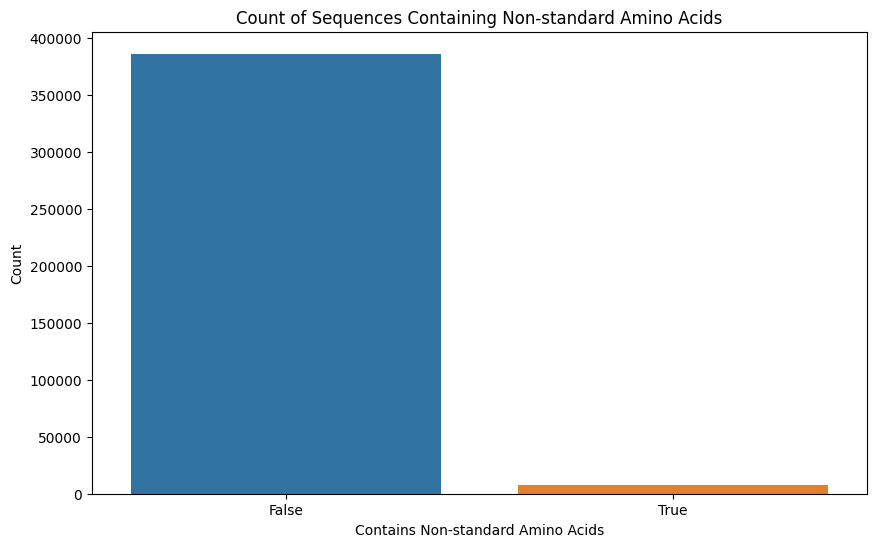

In [28]:
plt.figure(figsize=(10, 6))
sns.countplot(x='has_nonstd_aa', data=df)
plt.title('Count of Sequences Containing Non-standard Amino Acids')
plt.xlabel('Contains Non-standard Amino Acids')
plt.ylabel('Count')
plt.show()

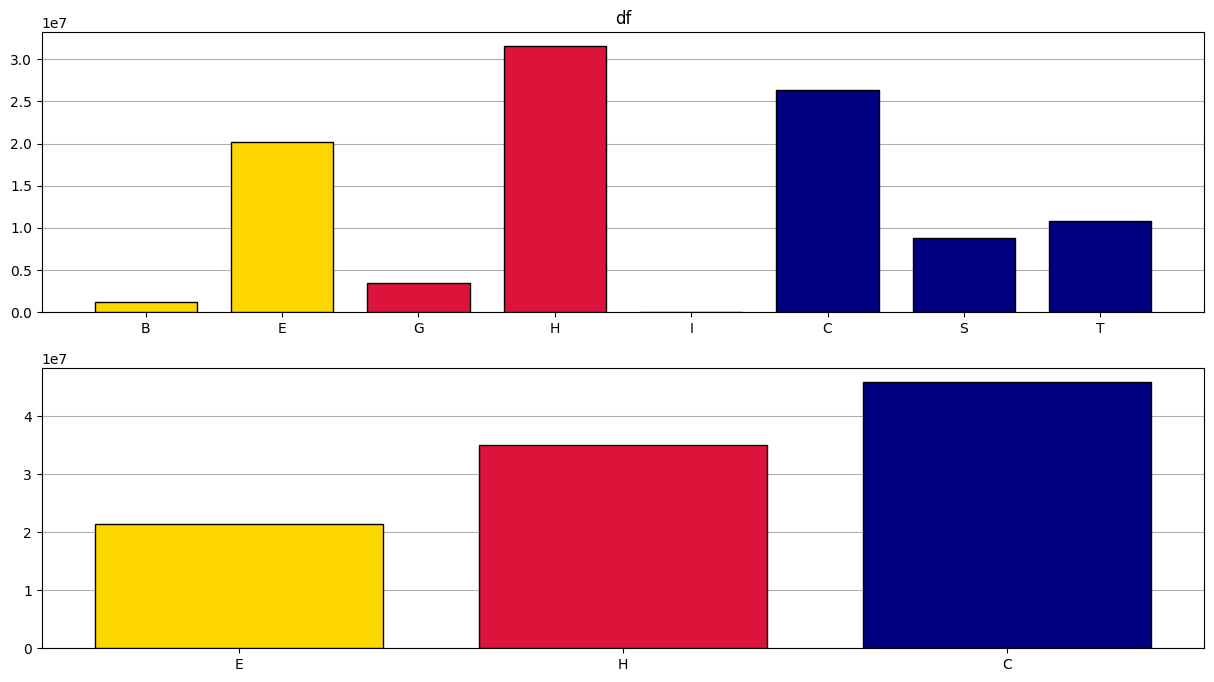

In [29]:
SS_counts = {'df': {'SST-8': defaultdict(lambda: 0), 'SST-3': defaultdict(lambda: 0)}}

for seq in df['sst8']:
    for ss in set(seq):
        SS_counts['df']['SST-8'][ss] += seq.count(ss)
        
for seq in df['sst3']:
    for ss in set(seq):
        SS_counts['df']['SST-3'][ss] += seq.count(ss)

ss8_types = ['B', 'E', 'G', 'H', 'I', 'C', 'S', 'T']
ss3_types = ['E', 'H', 'C']

sst8_colors = ['gold', 'gold', 'crimson', 'crimson', 'crimson', 'navy', 'navy', 'navy']
sst3_colors = ['gold', 'crimson', 'navy']

fig, axs = plt.subplots(2, 1, sharey='row', figsize=(15, 8))

axs[0].bar(range(8), height=[SS_counts['df']['SST-8'][ss] for ss in ss8_types],
          tick_label=ss8_types, edgecolor='black', width=0.75, zorder=3, color=sst8_colors)
axs[0].grid(axis='y', which='both', zorder=0)
axs[0].title.set_text('df')

axs[1].bar(range(3), height=[SS_counts['df']['SST-3'][ss] for ss in ss3_types],
          tick_label=ss3_types, edgecolor='black', width=0.75, zorder=3, color=sst3_colors)
axs[1].grid(axis='y', which='both', zorder=0)

fig.show() 

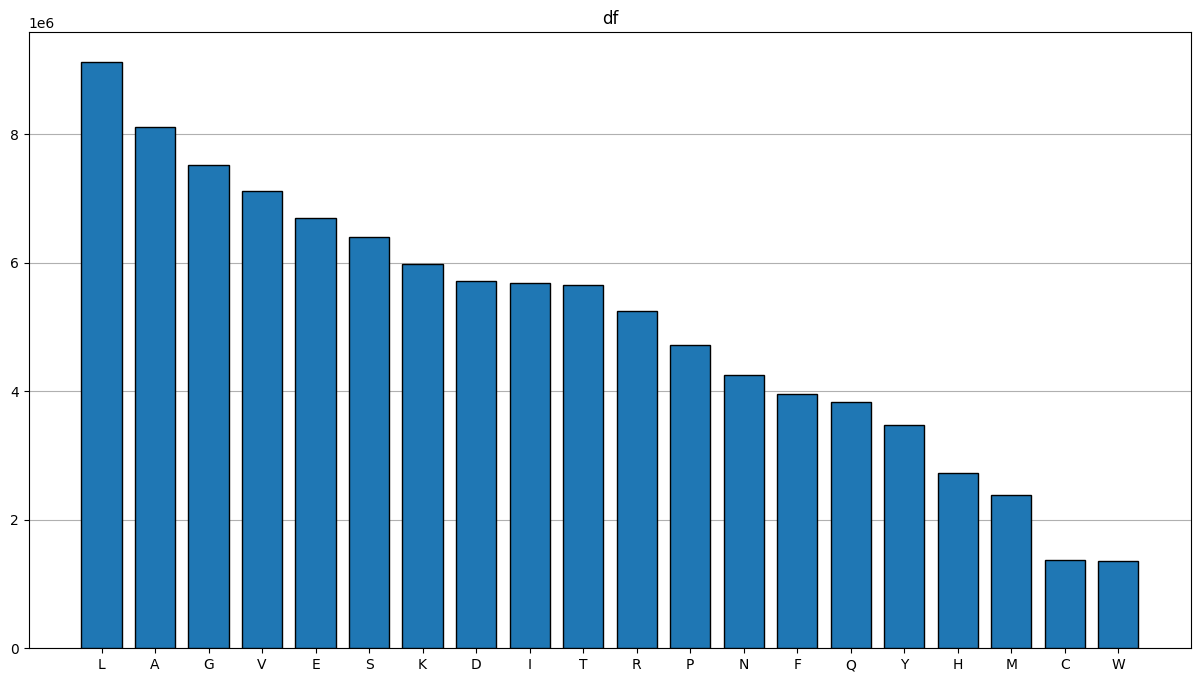

In [30]:
AA_counts = {'df': defaultdict(lambda: 0)}

for (seq, nonstd) in zip(df['seq'], df['has_nonstd_aa']):
    if not nonstd:
        for aa in set(seq):
            if aa != '*':
                AA_counts['df'][aa] += seq.count(aa)

total_aa = [AA_counts['df'][aa] for aa in AA_counts['df'].keys()]
temp = sorted(total_aa, reverse=True)
order = [total_aa.index(v) for v in temp]
aa_order = [list(AA_counts['df'].keys())[i] for i in order]

fig, axs = plt.subplots(1, 1, figsize=(15, 8))

axs.bar(range(20), height=[AA_counts['df'][aa] for aa in aa_order],
        tick_label=aa_order, edgecolor='black', width=0.75, zorder=3)
axs.grid(axis='y', which='both', zorder=0)
axs.title.set_text('df')

fig.show()


In [31]:
from collections import defaultdict
import pandas as pd

AA_counts = {'df': defaultdict(lambda: 0)}

for (seq, nonstd) in zip(df['seq'], df['has_nonstd_aa']):
    if not nonstd:
        for aa in set(seq):
            if aa != '*':
                AA_counts['df'][aa] += seq.count(aa)

total_aa = [AA_counts['df'][aa] for aa in AA_counts['df'].keys()]
temp = sorted(total_aa, reverse=True)
order = [total_aa.index(v) for v in temp]
aa_order = [list(AA_counts['df'].keys())[i] for i in order]

tbl_data = {'Amino Acid': aa_order,
            'df': [ round(AA_counts['df'][aa] / sum(AA_counts['df'].values()), 3) for aa in aa_order]}
pd.DataFrame(tbl_data)


,Amino Acid,df
0,L,0.090
1,A,0.080
2,G,0.074
3,V,0.070
4,E,0.066
5,S,0.063
6,K,0.059
7,D,0.056
8,I,0.056
9,T,0.056


(393732, 7)


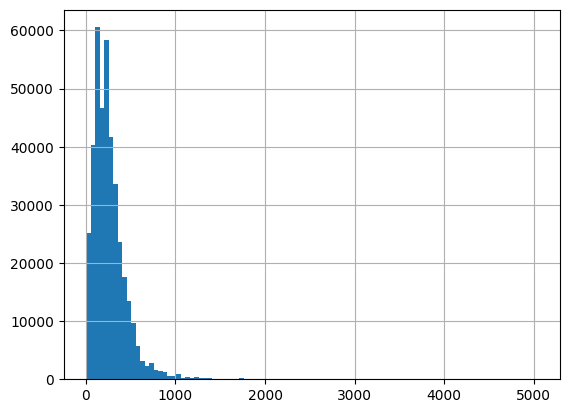

In [34]:
df = pd.read_csv('/kaggle/input/protein-secondary-structure/2018-06-06-ss.cleaned.csv')
df.len.hist(bins=100)
print(df.shape)

In [35]:
df.head()

,pdb_id,chain_code,seq,sst8,sst3,len,has_nonstd_aa
0,1A30,C,EDL,CBC,CEC,3,False
1,1B05,B,KCK,CBC,CEC,3,False
2,1B0H,B,KAK,CBC,CEC,3,False
3,1B1H,B,KFK,CBC,CEC,3,False
4,1B2H,B,KAK,CBC,CEC,3,False


In [45]:
def seq2ngrams(seqs, n=3):
    ngrams = []
    for seq in seqs:
        seq_ngrams = [seq[i:i+n] for i in range(len(seq) - n + 1)]
        ngrams.append(seq_ngrams)
    return ngrams


In [46]:
maxlen_seq = 128
input_seqs, target_seqs = df[['seq', 'sst3']][(df.len <= maxlen_seq) & (~df.has_nonstd_aa)].values.T

input_grams = seq2ngrams(input_seqs)
print(len(input_grams))

88751


# **PRE-PROCESSING**

In [47]:
tokenizer_encoder = Tokenizer()
tokenizer_encoder.fit_on_texts(input_grams)
input_data = tokenizer_encoder.texts_to_sequences(input_grams)
input_data = sequence.pad_sequences(input_data, maxlen=maxlen_seq, padding='post')

In [48]:
tokenizer_decoder = Tokenizer(char_level=True)
tokenizer_decoder.fit_on_texts(target_seqs)
target_data = tokenizer_decoder.texts_to_sequences(target_seqs)
target_data = sequence.pad_sequences(target_data, maxlen=maxlen_seq, padding='post')
target_data = to_categorical(target_data)
input_data.shape, target_data.shape

((88751, 128), (88751, 128, 4))

# **MODEL STRUCTURE**

In [49]:
n_words = len(tokenizer_encoder.word_index) + 1
n_tags = len(tokenizer_decoder.word_index) + 1
print(n_words, n_tags)

8001 4


In [51]:
input = Input(shape=(maxlen_seq,))
x = Embedding(input_dim=n_words, output_dim=128, input_length=maxlen_seq)(input)
x = Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.1))(x)
y = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [52]:
model = Model(input, y)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 128, 128)       │     1,024,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 128, 4)         │           516 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,123,460 (4.29 MB)

 Trainable params: 1,123,460 (4.29 MB)

 Non-trainable params: 0 (0.00 B)

# **Training and evaluation of the model**

In [53]:
def q3_acc(y_true, y_pred):
    y = tf.argmax(y_true, axis=-1)
    y_ = tf.argmax(y_pred, axis=-1)
    mask = tf.greater(y, 0)
    return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx())

In [54]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy", q3_acc])

In [55]:
X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=.4, random_state=0)
seq_train, seq_test, target_train, target_test = train_test_split(input_seqs, target_seqs, test_size=.4, random_state=0)

history = model.fit(X_train, y_train, batch_size=128, epochs=5, validation_data=(X_test, y_test), verbose=1)

Epoch 1/5
417/417 ━━━━━━━━━━━━━━━━━━━━ 239s 540ms/step - accuracy: 0.6588 - loss: 0.6904 - q3_acc: 0.4618 - val_accuracy: 0.6994 - val_loss: 0.5899 - val_q3_acc: 0.5235
Epoch 2/5
417/417 ━━━━━━━━━━━━━━━━━━━━ 221s 530ms/step - accuracy: 0.8122 - loss: 0.4357 - q3_acc: 0.7013 - val_accuracy: 0.8460 - val_loss: 0.3747 - val_q3_acc: 0.7559
Epoch 3/5
417/417 ━━━━━━━━━━━━━━━━━━━━ 259s 523ms/step - accuracy: 0.8582 - loss: 0.3477 - q3_acc: 0.7738 - val_accuracy: 0.8619 - val_loss: 0.3401 - val_q3_acc: 0.7811
Epoch 4/5
417/417 ━━━━━━━━━━━━━━━━━━━━ 252s 498ms/step - accuracy: 0.8729 - loss: 0.3180 - q3_acc: 0.7979 - val_accuracy: 0.8771 - val_loss: 0.3090 - val_q3_acc: 0.8052
Epoch 5/5
417/417 ━━━━━━━━━━━━━━━━━━━━ 265s 505ms/step - accuracy: 0.8826 - loss: 0.2956 - q3_acc: 0.8127 - val_accuracy: 0.8859 - val_loss: 0.2905 - val_q3_acc: 0.8191


# **RESULTS**

In [60]:
def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i]
        else:
            break
    return s

In [61]:
def plot_results(x, y, y_):
    print("---")
    print("Input: " + str(x))
    print("actual value: " + str(onehot_to_seq(y, reverse_decoder_index).upper()))
    print("Predicted value: " + str(onehot_to_seq(y_, reverse_decoder_index).upper()))
    fig = plt.figure(figsize=(10, 2))
    plt.imshow(y.T, cmap='Blues')
    plt.imshow(y_.T, cmap='Reds', alpha=.5)
    plt.yticks(range(4), [' '] + [reverse_decoder_index[i+1].upper() for i in range(3)])
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Training:
---
Input: MGDKPIWEQIGSSFINHYYQLFDNDRTQLGAIYIDASCLTWEGQQFQGKAAIVEKLSSLPFQKIQHSITAQDHQPTPDSCIISMVVGQLKADEDPIMGFHQEFLLKNINDAWVCTNDMFRLALHNFG
Expected result: CCCCCHHHHHHHHHHHHHHHHHHHCHHHHHHHCCCCCEEEECCEEEECHHHHHHHHHHCCCCCEEEEEEEEEEEECCCCCEEEEEEEEEEECCCCCEEEEEEEEEEECCCCEEEEEEEEEEECCCCC
Obtained result: CCCCCHHHHHHHHHHHHHHHHHCCCCCCCCHEEEEEEEEEECEEEEECHHHHHHHHCCCCCCCEEEEEEEEEEEECCCCEEEEEEEEEEEECCCCECEEEEEEEECCCCCCEEEEEEEEEEECCCCC


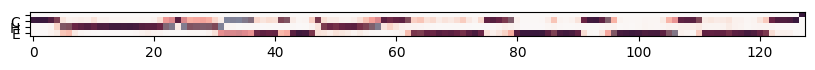

---
Input: SRGTQTE
Expected result: CEEEECC
Obtained result: CCCCCCC


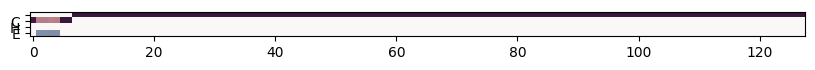

---
Input: MKEEKRSSTGFLVKQRAFLKLYMITMTEQERLYGLKLLKVLQSEFKEIGFKPNHTEVYRSLHELLDDGILKQIKVKKEGAKLQEVVLYQFKDYEAAKLYKKQLKVELDRCKKLIEKALSDNF
Expected result: CCCCCCCCCCCCCCHHHHHHHHHHHHHHCCCEECCCCHHHHHHHHCCCCCCCCHHHHHHHHHHHHHCCCEEEEECCCCCCCCCCCEEEEECCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHC
Obtained result: CCCCCCCCCCCCHHHHHHHHHHHHHHHHHHHCCCHHHHHHHHHHHHCCCCCCCHHHHHHHHHHHHCHCCCCECCCCCCCCCCCCEEEEEHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCC


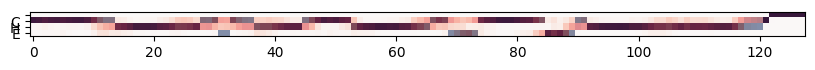

Testing:
---
Input: MKRQKRDRLERAHQRGYQAGIAGRSKEMCPYQTLNQRSQWLGGWREAMADRVVMAHHHHHH
Expected result: CCCCCHHHHHHHHHHHHHHHHCCCCCCCCCCCCHHHHHHHHHHHHHHHHHCCCCCCCCCCC
Obtained result: CCCCHHHHHHHHHHHHHHHHHCCHHHHHHHHHHHHHHHCCCCCHHHHHHHHCCCCCCCCCC


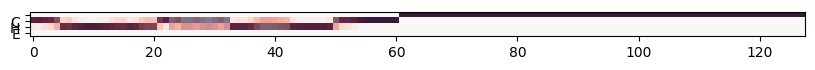

---
Input: YCQKWMWTCDEERKCCEGLVCRLWCKRIINM
Expected result: CCCCCCCECCCCCCCCCCCECCCECECCCCC
Obtained result: CCCCCCECCCCCCCEECCCCCECCCEEEEEC


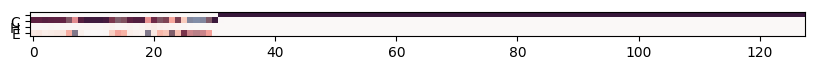

---
Input: TEFSEEQKRTLDLLFLFDRRMTEERRRWLSQRLGLNEEQIERWFRRKEQQI
Expected result: CCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCHHHHHHHHHCCCCCC
Obtained result: CCCCCCCCHHHHHHHHHHHHHHHHHHHHHHHHCCCCHHHHHHHHHHCCCCC


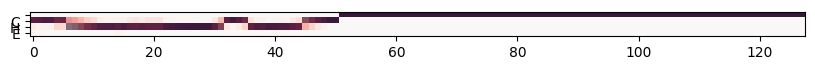

In [62]:
reverse_decoder_index = {value: key for key, value in tokenizer_decoder.word_index.items()}
reverse_encoder_index = {value: key for key, value in tokenizer_encoder.word_index.items()}

N = 3 
y_train_pred = model.predict(X_train[:N])
y_test_pred = model.predict(X_test[:N])

print('Training:')
for i in range(N):
    plot_results(seq_train[i], y_train[i], y_train_pred[i])

print('Testing:')
for i in range(N):
    plot_results(seq_test[i], y_test[i], y_test_pred[i])

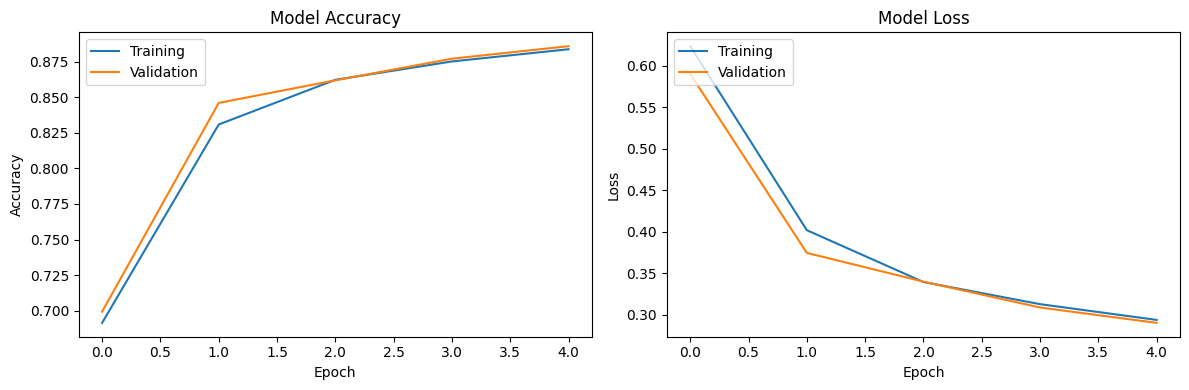

In [63]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()